In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

In [17]:
sns.set_style('darkgrid')
sns.set_palette('BrBG_r')

In [3]:
uri = './Client-Segmentation-master/BancoDeDados.csv'
df = pd.read_csv(uri)
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 116581 entries, 0 to 116580
Data columns (total 27 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   amostra               116581 non-null  int64  
 1   id_cliente            116581 non-null  object 
 2   id_unico_cliente      116581 non-null  object 
 3   item_id               116581 non-null  int64  
 4   cep_cliente           116581 non-null  int64  
 5   cidade_cliente        116581 non-null  object 
 6   estado_cliente        116581 non-null  object 
 7   id_pedido             116581 non-null  object 
 8   status_pedido         116581 non-null  object 
 9   horario_pedido        116581 non-null  object 
 10  pedido_aprovado       116567 non-null  object 
 11  pedido_entregador     115368 non-null  object 
 12  pedido_entregue       114066 non-null  object 
 13  data_estimada         116581 non-null  object 
 14  id_vendedor           116581 non-null  object 
 15  

### ANÁLISE VISUAL

In [4]:
def plot_perc(st, dados):
    plt.figure(figsize=(14,4))
    g = sns.countplot(x=st, data=dados, orient='h', palette='BrBG_r')
    g.set_ylabel('Contagem', fontsize=12)
    
    sizes = []
    for p in g.patches:
        height = p.get_height()
        sizes.append(height)
        g.text(p.get_x() + p.get_width()/1.6,
                height+200,
                f'{height/116581*100:.1f}%',
                ha='center', va='bottom', fontsize=10)
    g.set_ylim(0,max(sizes)*1.1)
                

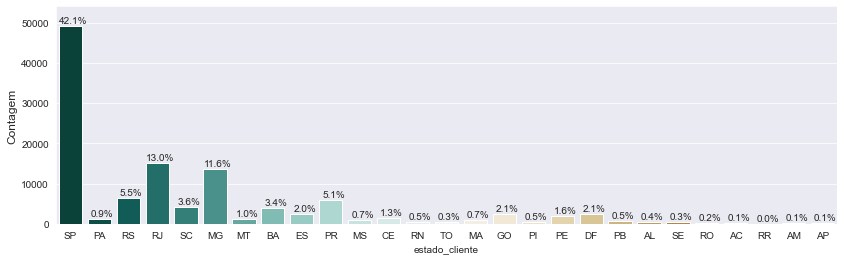

In [5]:
plot_perc('estado_cliente', df)

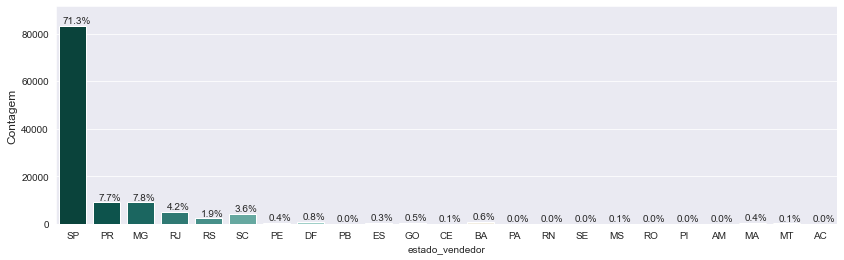

In [6]:
plot_perc('estado_vendedor', df)

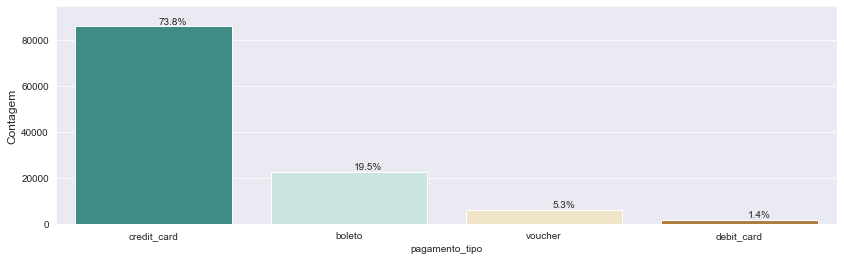

In [7]:
plot_perc('pagamento_tipo', df)

### ANÁLISE **RFM**

<div style="text-align:center">
    <img src='https://external-content.duckduckgo.com/iu/?u=https%3A%2F%2F1.bp.blogspot.com%2F-gl-s4XvmYBc%2FXTQl-ZBh-SI%2FAAAAAAAAAIQ%2FMWQLA9c4mqczLRoMhzgY1JwZk10P2cqWgCLcBGAs%2Fs640%2FIncontent_image.png&f=1&nofb=1' height=300px>
</div>

In [8]:
df_olist = df[['id_unico_cliente', 'id_cliente', 'horario_pedido', 'item_id', 'preco']]

In [9]:
df_compra = df.groupby(by='id_unico_cliente', as_index=False).horario_pedido.max()
df_compra.columns = ['id_unico_cliente', 'DataMaxCompra']
df_compra.DataMaxCompra = pd.to_datetime(df_compra['DataMaxCompra'])

In [10]:
df_compra['Recencia'] = (df_compra['DataMaxCompra'].max() - df_compra['DataMaxCompra']).dt.days

In [37]:
df_usuario = pd.merge(df_olist, df_compra[['id_unico_cliente', 'Recencia']], on='id_unico_cliente')
df_usuario.head()

,id_unico_cliente,id_cliente,horario_pedido,item_id,preco,Recencia
0,861eff4711a542e4b93843c6dd7febb0,06b8999e2fba1a1fbc88172c00ba8bc7,2017-05-16 15:05:35,1,124.99,474
1,9eae34bbd3a474ec5d07949ca7de67c0,8912fc0c3bbf1e2fbf35819e21706718,2017-11-09 00:50:13,1,112.99,298
2,9eae34bbd3a474ec5d07949ca7de67c0,8912fc0c3bbf1e2fbf35819e21706718,2017-11-09 00:50:13,2,112.99,298
3,3c799d181c34d51f6d44bbbc563024db,f0ac8e5a239118859b1734e1087cbb1f,2017-05-07 20:11:26,1,124.99,483
4,23397e992b09769faf5e66f9e171a241,6bc8d08963a135220ed6c6d098831f84,2018-02-03 19:45:40,1,106.99,211


### CLUSTERIZAÇÃO

#### NÚMERO DE CLUSTERS

In [12]:
from sklearn.cluster import KMeans

def calcular_wcss(data): #within-cluster sums of squares
    wcss = []
    for k in range(2,10):
        kmeans = KMeans(n_clusters=k)
        kmeans.fit(X=data)
        # data['Clusters'+'k = '+str(k)] = kmeans.labels_
        wcss.append(kmeans.inertia_)
    return wcss

In [13]:
df_recencia = df_usuario[['Recencia']]
df_recencia.head()

,Recencia
0,474
1,298
2,298
3,483
4,211


In [14]:
soma_quadrados = calcular_wcss(df_recencia)

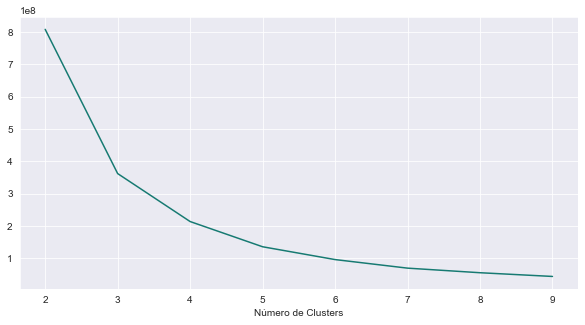

In [18]:
plt.figure(figsize=(10,5))
plt.plot(range(2,10),soma_quadrados)
plt.xlabel('Número de Clusters')
plt.show()

**regra do cotovelo**
- o número de clusters escolhido será o com a maior distância da reta representada em vermelho  

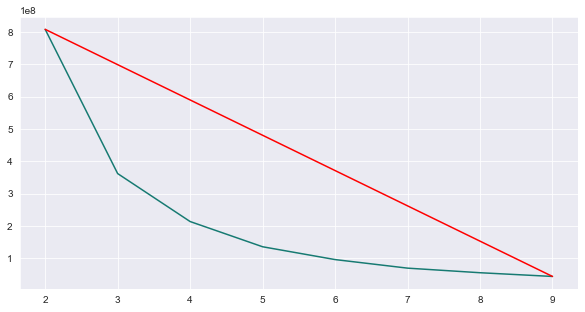

In [19]:
plt.figure(figsize=(10,5))
plt.plot(range(2,10),soma_quadrados)
plt.plot([2,9],[soma_quadrados[0],soma_quadrados[-1]], color='r')

In [20]:
def calcula_dist(k):
    x0 = 2
    y0 = soma_quadrados[0]
    x1 = 9
    y1 = soma_quadrados[-1]
    x = k
    y = soma_quadrados[k-2]
    
    dist = abs((y1-y0)*x - (x1-x0)*y + x1*y0 - y1*x0)\
            /np.sqrt((y1-y0)**2 + (x1-x0)**2)
            
    return dist

In [21]:
distancias = []
for k in range(2,10):
    print(k, calcula_dist(k).round(4))
    distancias.append(calcula_dist(k))
    
print('MAX:', np.max(distancias).round(4))
print('Número de Clusters:', distancias.index(max(distancias))+2)

2 0.0
3 3.0859
4 3.4446
5 3.1589
6 2.5221
7 1.7647
8 0.8946
9 0.0
MAX: 3.4446
Número de Clusters: 4


#### CLUSTERIZANDO A RECENCIA

In [38]:
kmeans = KMeans(n_clusters=4)
df_usuario['RecenciaCluster'] = kmeans.fit_predict(df_recencia)
df_usuario.head()

,id_unico_cliente,id_cliente,horario_pedido,item_id,preco,Recencia,RecenciaCluster
0,861eff4711a542e4b93843c6dd7febb0,06b8999e2fba1a1fbc88172c00ba8bc7,2017-05-16 15:05:35,1,124.99,474,2
1,9eae34bbd3a474ec5d07949ca7de67c0,8912fc0c3bbf1e2fbf35819e21706718,2017-11-09 00:50:13,1,112.99,298,1
2,9eae34bbd3a474ec5d07949ca7de67c0,8912fc0c3bbf1e2fbf35819e21706718,2017-11-09 00:50:13,2,112.99,298,1
3,3c799d181c34d51f6d44bbbc563024db,f0ac8e5a239118859b1734e1087cbb1f,2017-05-07 20:11:26,1,124.99,483,2
4,23397e992b09769faf5e66f9e171a241,6bc8d08963a135220ed6c6d098831f84,2018-02-03 19:45:40,1,106.99,211,3


In [39]:
groupby_cluster = df_usuario.groupby('RecenciaCluster', as_index=False).mean()
groupby_cluster = groupby_cluster.sort_values(by='Recencia').reset_index(drop=True)
groupby_cluster['trueRecenciaCluster'] = groupby_cluster.index
groupby_cluster

,RecenciaCluster,item_id,preco,Recencia,trueRecenciaCluster
0,0,1.193426,122.581839,66.790878,0
1,3,1.202057,117.352976,187.911204,1
2,1,1.208252,120.548234,320.233294,2
3,2,1.176884,123.821147,490.622269,3


In [40]:
df_recencia_cluster = pd.merge(df_usuario, groupby_cluster[['RecenciaCluster', 'trueRecenciaCluster']], on='RecenciaCluster')
df_recencia_cluster.drop('RecenciaCluster', axis=1, inplace=True)
df_recencia_cluster.rename(columns={'trueRecenciaCluster':'RecenciaCluster'}, inplace=True)

In [41]:
df_recencia_cluster.head()

,id_unico_cliente,id_cliente,horario_pedido,item_id,preco,Recencia,RecenciaCluster
0,861eff4711a542e4b93843c6dd7febb0,06b8999e2fba1a1fbc88172c00ba8bc7,2017-05-16 15:05:35,1,124.99,474,3
1,3c799d181c34d51f6d44bbbc563024db,f0ac8e5a239118859b1734e1087cbb1f,2017-05-07 20:11:26,1,124.99,483,3
2,567ab47ca4deb92d46dbf54dce07d0a7,fd3a0b1bd209f0e7d420c9c3d1127613,2017-03-23 15:10:17,1,126.99,528,3
3,f40ab89b622248b7ca125af4b486b887,fbd40c083aa8cddebb5265b2ba6aaf2e,2017-05-16 10:00:49,1,124.99,474,3
4,749943913a9851a39c9baf51877fbab6,10558ef4afea173bfb5e2cbe3d5b0bb5,2017-03-18 23:04:36,1,126.99,533,3


In [42]:
def ordenador_cluster(cluster_nome, target_nome, df, ascending=True):
    groupby_cluster = df.groupby(cluster_nome, as_index=False)[target_nome].mean()
    groupby_cluster = groupby_cluster.sort_values(by=target_nome, ascending=ascending).reset_index(drop=True)
    groupby_cluster['index'] = groupby_cluster.index
    df_final = pd.merge(df, groupby_cluster[[cluster_nome, 'index']], on=cluster_nome)
    df_final.drop(cluster_nome, axis=1, inplace=True)
    df_final.rename(columns={'index':cluster_nome}, inplace=True)
    return df_final

In [43]:
df_usuario = ordenador_cluster('RecenciaCluster', 'Recencia', df_usuario, ascending=False)
df_usuario.head()

,id_unico_cliente,id_cliente,horario_pedido,item_id,preco,Recencia,RecenciaCluster
0,861eff4711a542e4b93843c6dd7febb0,06b8999e2fba1a1fbc88172c00ba8bc7,2017-05-16 15:05:35,1,124.99,474,0
1,3c799d181c34d51f6d44bbbc563024db,f0ac8e5a239118859b1734e1087cbb1f,2017-05-07 20:11:26,1,124.99,483,0
2,567ab47ca4deb92d46dbf54dce07d0a7,fd3a0b1bd209f0e7d420c9c3d1127613,2017-03-23 15:10:17,1,126.99,528,0
3,f40ab89b622248b7ca125af4b486b887,fbd40c083aa8cddebb5265b2ba6aaf2e,2017-05-16 10:00:49,1,124.99,474,0
4,749943913a9851a39c9baf51877fbab6,10558ef4afea173bfb5e2cbe3d5b0bb5,2017-03-18 23:04:36,1,126.99,533,0


In [44]:
df_usuario.groupby('RecenciaCluster')['Recencia'].describe()

,count,mean,std,min,25%,50%,75%,max
RecenciaCluster,,,,,,,,
0,20324.0,490.622269,59.293154,406.0,444.0,481.0,533.0,728.0
1,30828.0,320.233294,43.971639,255.0,281.0,314.0,357.0,405.0
2,33639.0,187.911204,35.134736,128.0,158.0,187.0,218.0,254.0
3,31790.0,66.790878,36.009443,0.0,33.0,67.0,100.0,127.0


#### CLUSTERIZANDO A FREQUÊNCIA

In [45]:
df_frequencia = df.groupby('id_unico_cliente', as_index=False).pedido_aprovado.count()
df_frequencia.columns = ['id_unico_cliente', 'Frequencia']
df_frequencia.head()

,id_unico_cliente,Frequencia
0,0000366f3b9a7992bf8c76cfdf3221e2,1
1,0000b849f77a49e4a4ce2b2a4ca5be3f,1
2,0000f46a3911fa3c0805444483337064,1
3,0000f6ccb0745a6a4b88665a16c9f078,1
4,0004aac84e0df4da2b147fca70cf8255,1


In [46]:
df_usuario = pd.merge(df_usuario, df_frequencia, on=['id_unico_cliente'])
df_usuario.head()

,id_unico_cliente,id_cliente,horario_pedido,item_id,preco,Recencia,RecenciaCluster,Frequencia
0,861eff4711a542e4b93843c6dd7febb0,06b8999e2fba1a1fbc88172c00ba8bc7,2017-05-16 15:05:35,1,124.99,474,0,1
1,3c799d181c34d51f6d44bbbc563024db,f0ac8e5a239118859b1734e1087cbb1f,2017-05-07 20:11:26,1,124.99,483,0,1
2,567ab47ca4deb92d46dbf54dce07d0a7,fd3a0b1bd209f0e7d420c9c3d1127613,2017-03-23 15:10:17,1,126.99,528,0,1
3,f40ab89b622248b7ca125af4b486b887,fbd40c083aa8cddebb5265b2ba6aaf2e,2017-05-16 10:00:49,1,124.99,474,0,1
4,749943913a9851a39c9baf51877fbab6,10558ef4afea173bfb5e2cbe3d5b0bb5,2017-03-18 23:04:36,1,126.99,533,0,1


In [47]:
df_frequencia = df_usuario[['Frequencia']]
kmeans = KMeans(n_clusters=4)
df_usuario['FrequenciaCluster'] = kmeans.fit_predict(df_frequencia)
df_usuario.groupby('FrequenciaCluster')['Frequencia'].describe()

,count,mean,std,min,25%,50%,75%,max
FrequenciaCluster,,,,,,,,
0,106570.0,1.306343,0.570539,0.0,1.0,1.0,2.0,3.0
1,619.0,22.844911,6.267127,15.0,19.0,22.0,24.0,38.0
2,9317.0,5.744875,2.312449,4.0,4.0,5.0,6.0,14.0
3,75.0,75.000000,0.000000,75.0,75.0,75.0,75.0,75.0


In [48]:
df_usuario = ordenador_cluster('FrequenciaCluster', 'Frequencia', df_usuario)
df_usuario.groupby('FrequenciaCluster')['Frequencia'].describe()

,count,mean,std,min,25%,50%,75%,max
FrequenciaCluster,,,,,,,,
0,106570.0,1.306343,0.570539,0.0,1.0,1.0,2.0,3.0
1,9317.0,5.744875,2.312449,4.0,4.0,5.0,6.0,14.0
2,619.0,22.844911,6.267127,15.0,19.0,22.0,24.0,38.0
3,75.0,75.000000,0.000000,75.0,75.0,75.0,75.0,75.0


#### CLUSTERIZANDO A RECEITA

In [49]:
df_receita = df.groupby('id_unico_cliente', as_index=False).pagamento_valor.sum()
df_receita.columns = ['id_unico_cliente', 'Receita']
df_usuario = pd.merge(df_usuario, df_receita, on='id_unico_cliente')
df_usuario.head()

,id_unico_cliente,id_cliente,horario_pedido,item_id,preco,Recencia,RecenciaCluster,Frequencia,FrequenciaCluster,Receita
0,861eff4711a542e4b93843c6dd7febb0,06b8999e2fba1a1fbc88172c00ba8bc7,2017-05-16 15:05:35,1,124.99,474,0,1,0,146.87
1,3c799d181c34d51f6d44bbbc563024db,f0ac8e5a239118859b1734e1087cbb1f,2017-05-07 20:11:26,1,124.99,483,0,1,0,140.61
2,567ab47ca4deb92d46dbf54dce07d0a7,fd3a0b1bd209f0e7d420c9c3d1127613,2017-03-23 15:10:17,1,126.99,528,0,1,0,142.05
3,f40ab89b622248b7ca125af4b486b887,fbd40c083aa8cddebb5265b2ba6aaf2e,2017-05-16 10:00:49,1,124.99,474,0,1,0,155.70
4,749943913a9851a39c9baf51877fbab6,10558ef4afea173bfb5e2cbe3d5b0bb5,2017-03-18 23:04:36,1,126.99,533,0,1,0,148.33


In [51]:
df_pagamento = df_usuario[['Receita']]
kmeans = KMeans(n_clusters=4)
df_usuario['ReceitaCluster'] = kmeans.fit_predict(df_pagamento)

In [52]:
df_usuario = ordenador_cluster('ReceitaCluster', 'Receita', df_usuario)

In [53]:
df_usuario.groupby('ReceitaCluster')['Receita'].describe()

,count,mean,std,min,25%,50%,75%,max
ReceitaCluster,,,,,,,,
0,114904.0,261.485763,377.283592,9.59,69.90,132.82,270.00,3080.96
1,1478.0,5900.843911,2894.129234,3083.40,3798.75,4875.25,7315.92,16313.60
2,191.0,27358.656911,10032.832924,17069.76,19167.26,25051.89,30186.00,45256.00
3,8.0,109312.640000,0.000000,109312.64,109312.64,109312.64,109312.64,109312.64


#### SEGMENTAÇÃO DE CLIENTES

In [60]:
df_usuario.columns

Index(['id_unico_cliente', 'id_cliente', 'horario_pedido', 'item_id', 'preco',
       'Recencia', 'RecenciaCluster', 'Frequencia', 'FrequenciaCluster',
       'Receita', 'ReceitaCluster'],
      dtype='object')

In [58]:
df_final = df_usuario[['id_unico_cliente',
                       'Recencia', 'RecenciaCluster',
                       'Frequencia', 'FrequenciaCluster',
                       'Receita', 'ReceitaCluster']]

df_final.tail()

,id_unico_cliente,Recencia,RecenciaCluster,Frequencia,FrequenciaCluster,Receita,ReceitaCluster
116576,0a0a92112bd4c708ca5fde585afaa872,338,1,8,1,109312.64,3
116577,0a0a92112bd4c708ca5fde585afaa872,338,1,8,1,109312.64,3
116578,0a0a92112bd4c708ca5fde585afaa872,338,1,8,1,109312.64,3
116579,0a0a92112bd4c708ca5fde585afaa872,338,1,8,1,109312.64,3
116580,0a0a92112bd4c708ca5fde585afaa872,338,1,8,1,109312.64,3


In [62]:
df_final['Pontuacao'] = df_final['RecenciaCluster'] + df_final['FrequenciaCluster']\
    + df_final['ReceitaCluster']

/var/folders/my/tfkgprgd2kxb_7t2n85c1g580000gn/T/ipykernel_26727/2867360889.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final['Pontuacao'] = df_final['RecenciaCluster'] + df_final['FrequenciaCluster']\


In [64]:
df_final.Pontuacao.describe()

count    116581.000000
mean          1.768213
std           1.119420
min           0.000000
25%           1.000000
50%           2.000000
75%           3.000000
max           7.000000
Name: Pontuacao, dtype: float64

In [65]:
df_final['Segmento'] = 'Inativo'
df_final.loc[df_final['Pontuacao'] >= 1, 'Segmento'] = 'Business'
df_final.loc[df_final['Pontuacao'] >= 3, 'Segmento'] = 'Master'
df_final.loc[df_final['Pontuacao'] >= 5, 'Segmento'] = 'Premium'

/var/folders/my/tfkgprgd2kxb_7t2n85c1g580000gn/T/ipykernel_26727/252246977.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final['Segmento'] = 'Inativo'
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


In [67]:
df_final.sample(10)

,id_unico_cliente,Recencia,RecenciaCluster,Frequencia,FrequenciaCluster,Receita,ReceitaCluster,Pontuacao,Segmento
100963,ac0e0373a6ffdce079f8359aa7b9b296,59,3,1,0,48.72,0,3,Master
61020,0f10d99ee99ca3d0489f2f2169b41ec3,185,2,3,0,312.15,0,2,Business
50976,1cb06b7940f5a52343bd4d3032d0c97d,192,2,1,0,49.18,0,2,Business
215,bbc4a49cc4f47303a5280aed498d80ed,531,0,1,0,142.05,0,0,Inativo
65027,a28d7299d0cd5fe841801574ecf7c5f7,186,2,1,0,327.82,0,2,Business
37125,dd6ca4bccbd21803d32139af5b908fd7,264,1,2,0,156.22,0,1,Business
81028,c87944388aa89c72ded8daf1fa95e60e,5,3,1,0,37.26,0,3,Master
44119,1ec52a2fda0a61ade7cb2c70b98bcedd,269,1,1,0,148.32,0,1,Business
6816,c9c0c82af514e815fa47534f71113ebe,512,0,1,0,1003.76,0,0,Inativo
114449,569aa12b73b5f7edeaa6f2a01603e381,452,0,26,2,62.68,0,2,Business


In [68]:
df_final.to_csv('RFM.csv', index=False)

### ANÁLISE VISUAL

In [75]:
def plot_segmento(x, y, data):
    plt.figure(figsize=(7,5))
    sns.scatterplot(x=x, y=y, hue='Segmento', data=data, size='Segmento',
                    sizes=(50, 150), size_order=['Premium', 'Master', 'Business', 'Inativo'],
                    palette='magma_r')

    plt.show()

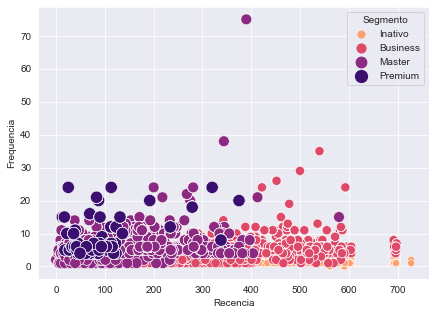

In [76]:
plot_segmento('Recencia','Frequencia', df_final)

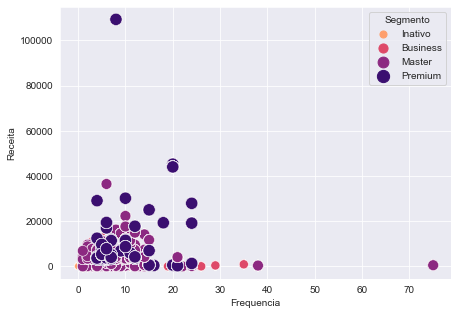

In [77]:
plot_segmento('Frequencia', 'Receita', df_final)

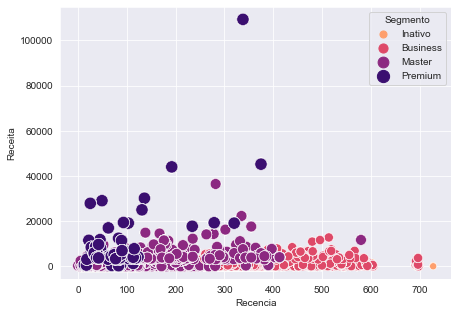

In [78]:
plot_segmento('Recencia', 'Receita', df_final)

<AxesSubplot:xlabel='Segmento', ylabel='count'>

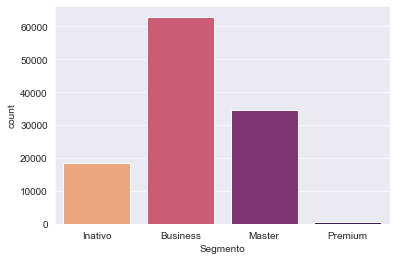

In [81]:
sns.countplot(x='Segmento', data=df_final, palette='magma_r')

In [85]:
from sklearn.metrics import silhouette_score

for i in range(2, 7):
    clusterer = KMeans(n_clusters=i)
    preds = clusterer.fit_predict(df_recencia)
    score = silhouette_score(df_recencia, preds)
    print('Silhueta para ' + str(i) + ' clusters : ' + str(score))

Silhueta para 2 clusters : 0.5987816654977525
Silhueta para 3 clusters : 0.576812024905756
Silhueta para 4 clusters : 0.5586178605174354
Silhueta para 5 clusters : 0.5586589301084736
Silhueta para 6 clusters : 0.5609249698859212


Podemos também criar outros tipos de segmentação com base nas campanhas de marketing que queremos explorar. Neste caso, fizemos uma clusterização com base na pontuação, ou seja, clientes que compram muito, mas com pouca frequência podem acabar tendo uma pontuação semelhante aos que gastam menos, mas com mais frequência. Para fazer uma análise mais completa, poderíamos criar uma tabela inteira se nos basearmos em uma pontuação de 1 a 5 como o exemplo abaixo:

| **Segmentos**        | **Descrição**                                                      | **Recência** | **Frequência** | **Receita** |
|----------------------|--------------------------------------------------------------------|--------------|----------------|-------------|
| Campeões             | Compraram recentemente, compram com frequência e gastam muito      | 4-5          | 4-5            | 4-5         |
| Clientes fiéis       | Gastam muito e respondem a promoções                               | 2-5          | 3-5            | 3-5         |
| Potencialmente fiéis | Compraram recentemente, mais de uma vez e gastaram uma boa quantia | 3-5          | 1-3            | 1-3         |
| Novos clientes       | Compraram recentemente, mas não compram com frequência             | 4-5          | <=1            | <=1         |
| Promissores          | Compraram recentemente, mas não gastaram muito                     | 3-4          | <=1            | <=1         |
| Precisam de atenção  | Recência, frequência e valor monetário acima da média              | 2-3          | 2-3            | 2-3         |
| Quase em risco       | Recência, frequência e valor monetário abaixo da média             | 2-3          | <=2            | <=2         |
| De risco             | Gastaram muito, compraram muitas vezes, mas há muito tempo         | <=2          | 2-5            | 2-5         |
| Não pode perdê-los   | Compraram muito e com frequência, mas há muito tempo               | <=1          | 4-5            | 4-5         |
| Hibernando           | Compraram pouco, com baixa frequência e há muito tempo             | 1-2          | 1-2            | 1-2         |
| Perdidos             | Recência, frequência e valores monetários baixos                   | <=2          | <=2            | <=2         |